<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/tutorials/W1D3_ModelFitting/student/W1D3_Tutorial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Neuromatch Academy: Week 1, Day 3, Tutorial 3
# Model Fitting: Confidence intervals and bootstrapping

#Tutorial Objectives

This is Tutorial 3 of a series on fitting models to data. We start with simple linear regression, using least squares optimization (Tutorial 1) and Maximum Likelihood Estimation (Tutorial 2). We will use bootstrapping to build confidence intervals around the inferred linear model parameters (Tutorial 3). We'll finish our exploration of linear models by  generalizing to multiple linear regression (Tutorial 4). We then move on to polynomial regression (Tutorial 5). We end by learning how to choose between these various models. We discuss the bias-variance trade-off (Tutorial 6) and two common methods for model selection, AIC and Cross Validation (Tutorial 7). 

In this tutorial, we wil discuss how to gauge how good our estimated model parameters are. 
- Learn how to use bootstrapping to generate new sample datasets
- Estimate our model parameter on these new sample datasets
- Quantify the variance of our estimate using confidence intervals

# Setup

In [1]:
# @title  Imports
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets


In [2]:
#@title Figure Settings
%matplotlib inline
fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
%config InlineBackend.figure_format = 'retina'

In [3]:
#@title Helper Functions
def solve_normal_eqn(x, y):
  """Solve the normal equations to produce the value of theta_hat that minimizes
    MSE.  
    
    Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.
    thata_hat (float): An estimate of the slope parameter. 

  Returns:
    float: The mean squared error of the data with the estimated parameter.
  """
  theta_hat = (x.T @ y) / (x.T @ x)
  return theta_hat

# Confidence Intervals and the Bootstrap

Video available at https://youtube.com/watch?v=6PZthKespNg


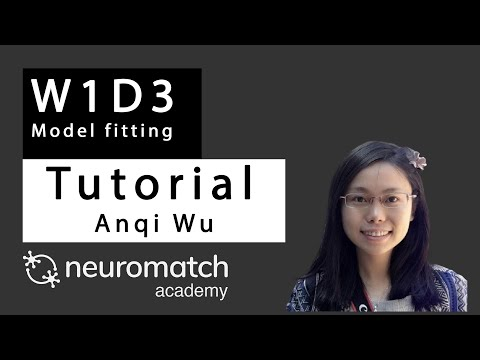

In [4]:
#@title Video: Bootstrapping
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="6PZthKespNg", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

Up to this point we have been finding ways to estimate model parameters to fit some observed data. Our approach has been to optimize some criterion, either minimize the mean squared error or maximize the likelihood while using the entire dataset. How good is our estimate really? How confident are we that it will generalize to describe new data we haven't seen yet?

One solution to this is to just collect more data and check the MSE on this new dataset with the previously estimated parameters. However this is not always feasible and still leaves open the question of how quantifiably confident we are in the accuracy of our model.

In this section we will explore how we can build confidence intervals of our estimates using the bootstrapping method.

### Bootstrapping

[Bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) is an elegent approach originally [proposed](https://projecteuclid.org/euclid.aos/1176344552) by [Bradley Efron](https://en.wikipedia.org/wiki/Bradley_Efron), that generates several new sample datasets from our existing one by randomly sampling from it, finding estimators for each one of these new datasets, and then looking at the statistics of the distribution of estimators to quantify our confidence.

In this case, our new datasets will be the same size as our original one, with the new data points sampled with replacement i.e. we can repeat the same data point multiple times (an alternatively omit others entirely).

To explore this idea, we wil start again with our noisy samples along the line $y = 1.2x$, but this time only use half the data points as last time (15 instead of 30).

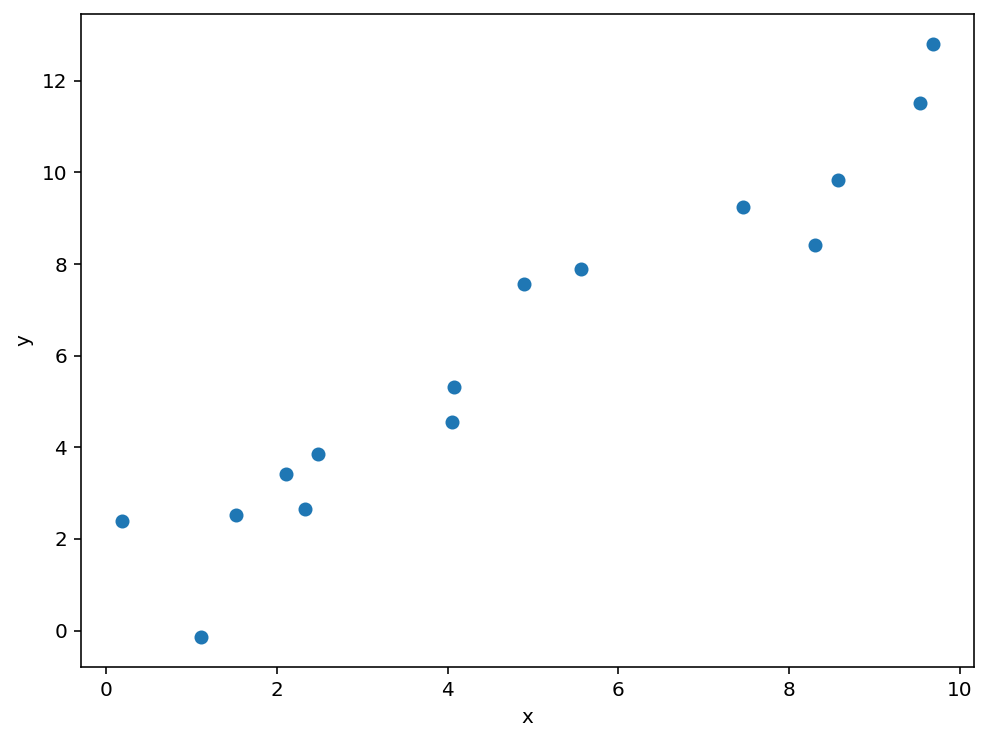

In [5]:
# setting a fixed seed to our random number generator ensures we will always
# get the same psuedorandom number sequence
np.random.seed(121)
theta = 1.2
n_samples = 15
x = 10*np.random.rand(n_samples) # sample from a uniform distribution over [0,10)
noise = np.random.randn(n_samples) # sample from a standard normal distribution
y = theta*x + noise

fig, ax = plt.subplots()
ax.scatter(x, y)  # produces a scatter plot
ax.set(xlabel='x', ylabel='y');

### Exercise: Resample Dataset with Replacement

In this exercise you will implement a method to resample a dataset with replacement. The method accepts $x$ and $y$ arrays. It should return a new set of $x'$ and $y'$ arrays that are created by randomly sampling from the originals.

TIP: The [numpy.random.choice](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) method would be useful here.

In [6]:
def resample_with_replacement(x, y):
  """Resample data points with replacement from the dataset of `x` inputs and
  `y` measurements.

  Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.

  Returns:
    ndarray, ndarray: The newly resampled `x` and `y` data points.
  """
  #######################################################
  ## TODO for students: resample dataset with replacement
  #######################################################
  # comment this out when you've filled
  raise NotImplementedError("Student excercise: resample dataset with replacement")
  return x_, y_

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W1D3_ModelFitting/solutions/W1D3_Tutorial3_Solution_0cc39c98.py)



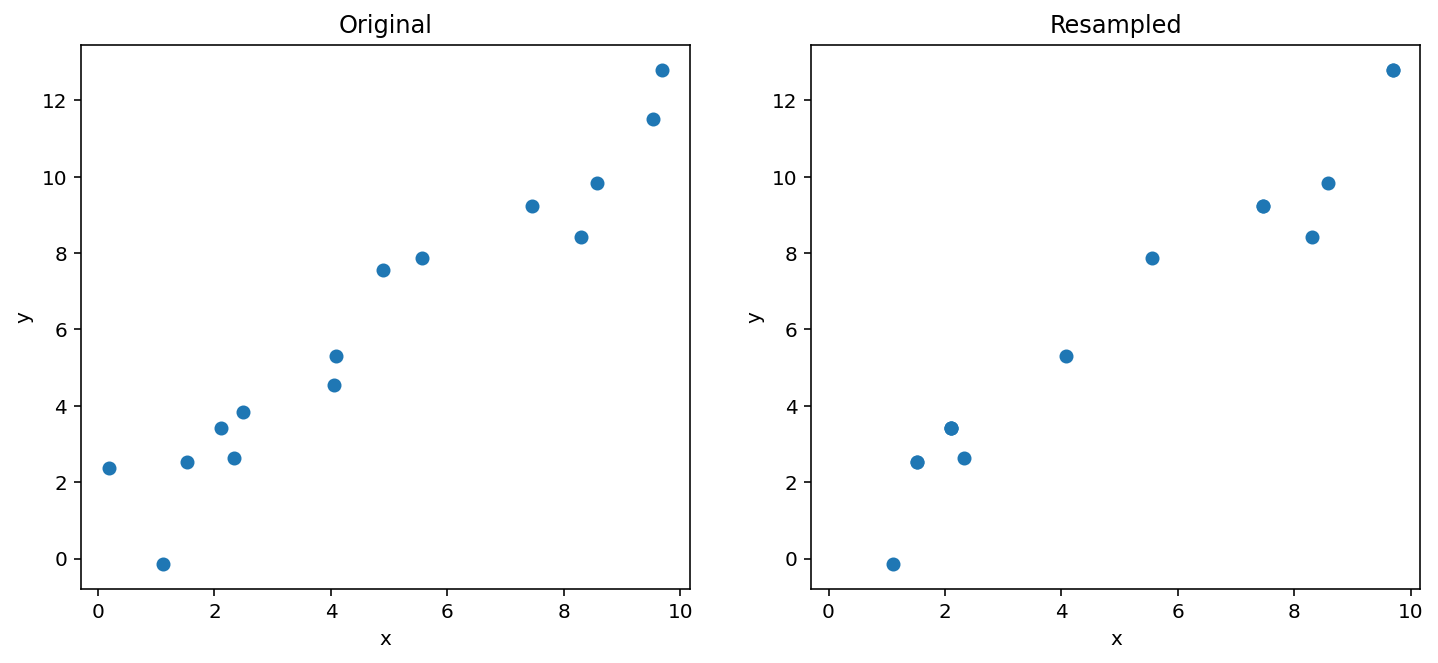

In [8]:
x_, y_ = resample_with_replacement(x, y)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))  
ax1.scatter(x, y)
ax1.set(title='Original', xlabel='x', ylabel='y')
ax2.scatter(x_, y_)
ax2.set(title='Resampled', xlabel='x', ylabel='y', 
        xlim=ax1.get_xlim(), ylim=ax1.get_ylim());

If you run the above cell multiple times, you should see the right-hand figure change to show a similar looking plot, though with likely fewer displayed points. The actual number of points is the same, but some have been repeated so they only display once.

Now that we have a way to resample the data, we can use that in the full bootstrapping process.

### Exercise: Bootstrap Estimates

In this exercise you will implement a method to run the bootstrap process of generating a set of $\hat\theta$ values from a dataset of $x$ inputs and $y$ measurements. You should use `resample_with_replacement` here, and you may also invoke `solve_normal_eqn` from Tutorial 1 to produce the MSE-based estimator.


In [9]:
def bootstrap_estimates(x, y, n=1000):
  """Generate a set of theta_hat estimates using the bootstrap method.
    
  Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.
    n (int): The number of estimates to compute

  Returns:
    ndarray: An array of estimated parameters with size (n,)
  """
  theta_hats = np.zeros(n)
  ######################################################################
  ## TODO for students: implement bootstrap estimation
  ######################################################################
  # comment this out when you've filled
  raise NotImplementedError("Student excercise: implement bootstrap estimation")
  return theta_hats

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W1D3_ModelFitting/solutions/W1D3_Tutorial3_Solution_366c3e68.py)



In [11]:
theta_hats = bootstrap_estimates(x, y, n=1000)
print(theta_hats[0:5])

[1.20042966 1.2117598  1.24232582 1.23934581 1.33404716]


Now that we have our bootstrap estimates, we can visualize all the potential models together to see how distributed they are.

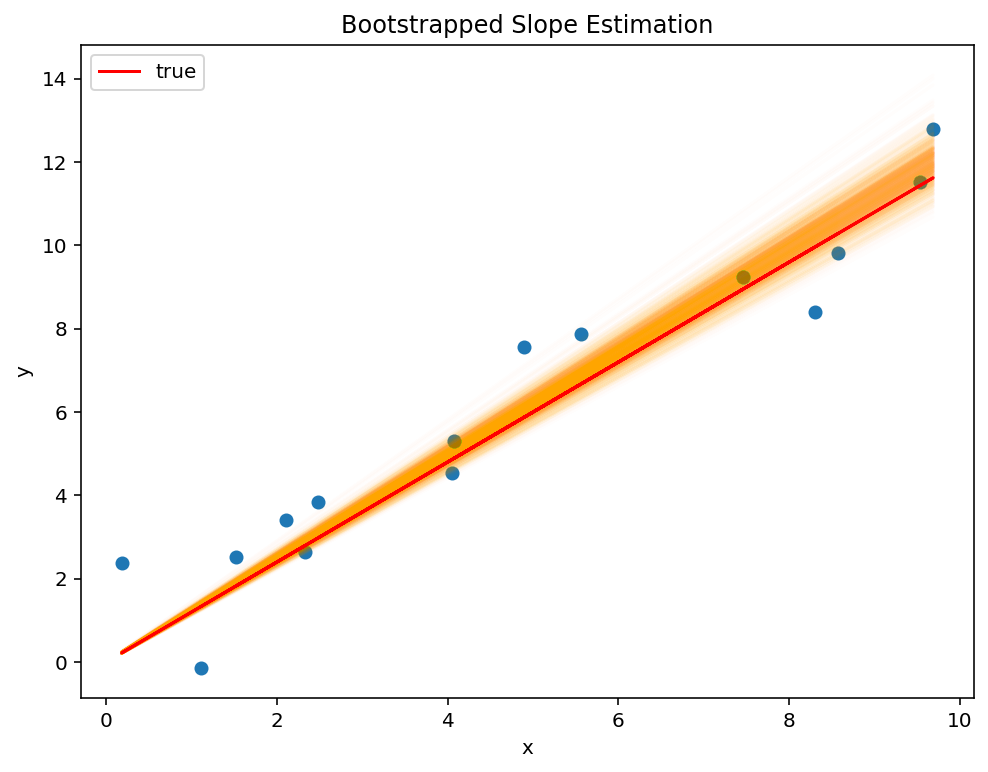

In [12]:
fig, ax = plt.subplots()

for theta_hat in theta_hats:
  y_hat = theta_hat * x
  ax.plot(x, y_hat, c='orange', alpha=0.01)

ax.scatter(x, y)

y_true = theta * x
ax.plot(x, y_true, 'r', label='true')

ax.set(
  title='Bootstrapped Slope Estimation',
  xlabel='x',
  ylabel='y'
)
ax.legend();

This looks pretty good! While there is some variance around the true model, it still seems fairly close. We can quantify this closeness by computing some summary statistics and constructing [confidence intervals](https://www.google.com/url?q=https://online.stat.psu.edu/stat504/node/19/&sa=D&ust=1592839697848000&usg=AFQjCNGaH-6a01eBgZygNc5obwD07cmqXA) from our estimate distribution.

mean = 1.24, std = 0.05


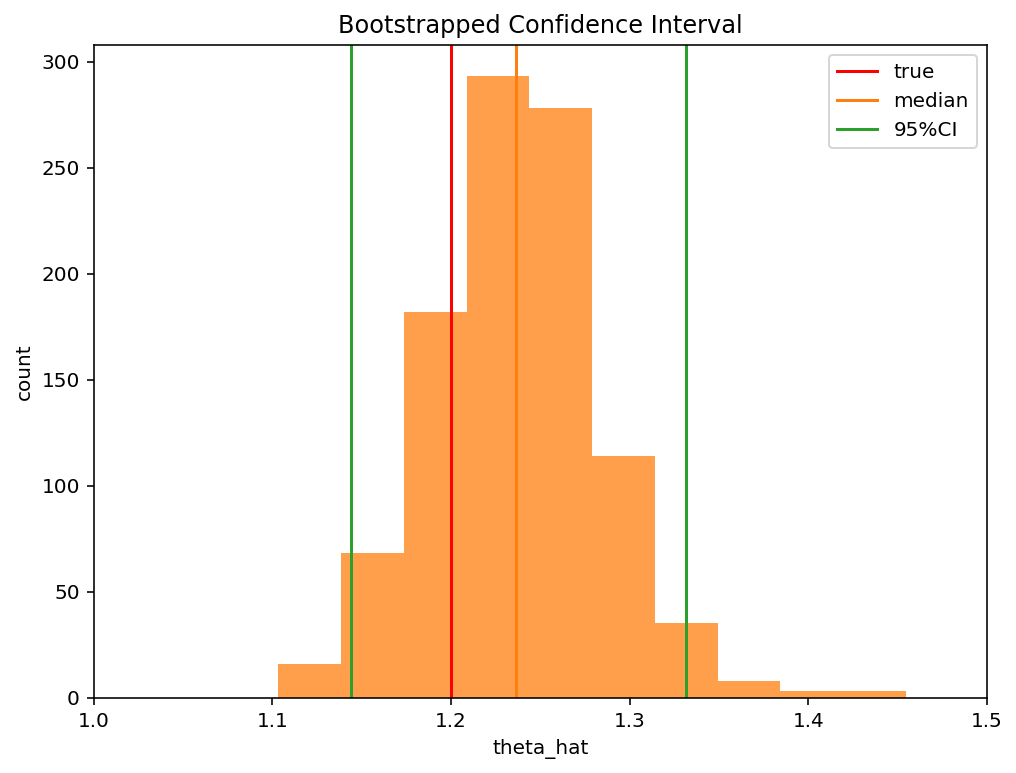

In [13]:
print(f"mean = {np.mean(theta_hats):.2f}, std = {np.std(theta_hats):.2f}")

fig, ax = plt.subplots()
ax.hist(theta_hats, facecolor='C1', alpha=0.75)
ax.axvline(theta, c='r', label='true')
ax.axvline(np.percentile(theta_hats, 50), color='C1', label='median')
ax.axvline(np.percentile(theta_hats, 2.5), color='C2', label='95%CI')
ax.axvline(np.percentile(theta_hats, 97.5), color='C2')
ax.legend()
ax.set(
    title='Bootstrapped Confidence Interval',
    xlabel='theta_hat',
    ylabel='count',
    xlim=[1.0, 1.5]
);

Looking at the distribution of bootstrapped $\hat{\theta}$ values, we see that the true $\theta$ falls well within our 95% confidence interval.

# Summary

- Bootstrapping is a resampling procedure that gives confidence intervals around inferred parameter values
- this method is very practical and relies on computational power as a resource